# HW05 - ChBE 413
**Name:** Mikkel Flores  
**Due Date:** October 2, 2025

**General Imports**

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, Ridge, LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

from scipy.stats import pearsonr
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, DataStructs, rdFingerprintGenerator, Draw, rdMolDescriptors

# Question 1: K-Nearest Neighbors Classification of Solubility

**Part (a)**

In [ ]:
df = pd.read_csv("solubility_classification.csv")
features = ['MolLogP','HeavyAtomCount','NumHAcceptors','NumHDonors', 'NumHeteroatoms','NumRotatableBonds','NumAromaticRings',
            'NumSaturatedRings','NumAliphaticRings','RingCount','TPSA','BalabanJ']

X = df[features]
y = df['Solubility']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

k_range = range(1, 51)
mean_scores = []
std_scores = []

for k in k_range:
    pipe = Pipeline([('scaler', StandardScaler()),
                     ('knn', KNeighborsClassifier(n_neighbors=k))])
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy')
    mean_scores.append(scores.mean())
    std_scores.append(scores.std())

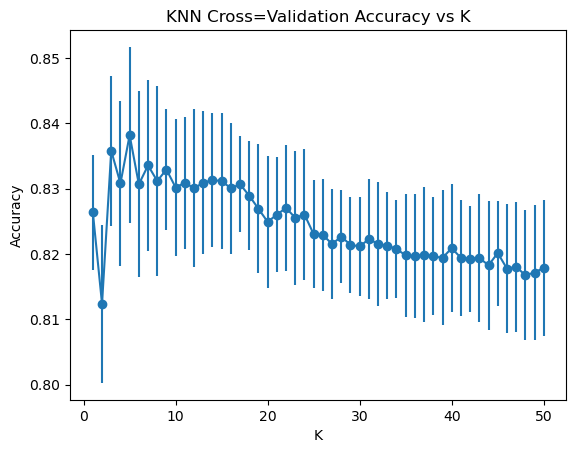

In [62]:
plt.errorbar(k_range, mean_scores, yerr=std_scores, fmt='o-')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('KNN Cross=Validation Accuracy vs K')
plt.show()

In [39]:
best_k = k_range[np.argmax(mean_scores)]
print(f'Best K: {best_k} with accuracy: {max(mean_scores):.4f}')

Best K: 5 with accuracy: 0.8382


In [40]:
final_pipe = Pipeline([('scaler', StandardScaler()),
                       ('knn', KNeighborsClassifier(n_neighbors=best_k))])

final_pipe.fit(X_train, y_train)

idx = list(k_range).index(best_k)
cv_mean = mean_scores[idx]
cv_std = std_scores[idx]

test_accuracy = final_pipe.score(X_test, y_test)
test_error = 1 - test_accuracy
print(f"Chosen K: {best_k}")
print(f"5-fold CV at K={best_k}: mean accuracy = {cv_mean:.4f} ± {cv_std:.4f}")
print(f"Held out test accuracy = {test_accuracy:.4f}, error = {test_error:.4f}")

Chosen K: 5
5-fold CV at K=5: mean accuracy = 0.8382 ± 0.0135
Held out test accuracy = 0.8398, error = 0.1602


**Part (b)**

In KNN classification, small values of K lead to low bias but high variance because the model is sensitive to local fluctuations in the training data. Large values of K "smooth" over more neighbors, which reduces variance but increases bias. The optimal K=5 I found balances this tradeoff between Bias and Variance for K, allowing me to get lower test error by characterizing the structure of the local data without overfitting to the inherent noise.

**Part (c)**

In [66]:
def smiles_to_morgan_bitvec(smiles_list, radius=2, n_bits=2048, labels=None):
    fps, keep_labels = [], []
    for i, smi in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            continue
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=n_bits)
        fps.append(fp)
        if labels is not None:
            keep_labels.append(labels[i])   
    return (fps, np.array(keep_labels)) if labels is not None else fps  

In [67]:
def knn_predict_1(test_fp, train_fps, train_labels, k=7):
    similarities = [DataStructs.TanimotoSimilarity(test_fp, fp) for fp in train_fps]
    top_idx = np.argsort(similarities)[-k:]
    votes = np.array(train_labels)[top_idx]
    return int(votes.mean() >= 0.5)

In [68]:
def knn_predict(test_fps, train_fps, train_labels, k=7):
    return np.array([knn_predict_1(fp, train_fps, train_labels, k) for fp in test_fps])

In [69]:
smiles_1c = df['SMILES'].tolist()
y_1c = df['Solubility'].values
fps_1c, y_1c = smiles_to_morgan_bitvec(smiles_1c, radius=2, n_bits=1024, labels=y_1c)

Xtr_1c, Xte_1c, ytr_1c, yte_1c = train_test_split(fps_1c, y_1c, test_size=0.2, random_state=42, stratify=y_1c)

ypred_1c = knn_predict(Xte_1c, Xtr_1c, ytr_1c, k=7)

acc_1c = accuracy_score(yte_1c, ypred_1c)
err_1c = 1 - acc_1c

print(f"Tanimoto-KNN (K=7) test accuracy = {acc_1c:.4f}, error = {err_1c:.4f}")

[16:46:44] DEPRECATION WARNING: please use MorganGenerator
[16:46:44] DEPRECATION WARNING: please use MorganGenerator
[16:46:44] DEPRECATION WARNING: please use MorganGenerator
[16:46:44] DEPRECATION WARNING: please use MorganGenerator
[16:46:44] DEPRECATION WARNING: please use MorganGenerator
[16:46:44] DEPRECATION WARNING: please use MorganGenerator
[16:46:44] DEPRECATION WARNING: please use MorganGenerator
[16:46:44] DEPRECATION WARNING: please use MorganGenerator
[16:46:44] DEPRECATION WARNING: please use MorganGenerator
[16:46:44] DEPRECATION WARNING: please use MorganGenerator
[16:46:44] DEPRECATION WARNING: please use MorganGenerator
[16:46:44] DEPRECATION WARNING: please use MorganGenerator
[16:46:44] DEPRECATION WARNING: please use MorganGenerator
[16:46:44] DEPRECATION WARNING: please use MorganGenerator
[16:46:44] DEPRECATION WARNING: please use MorganGenerator
[16:46:44] DEPRECATION WARNING: please use MorganGenerator
[16:46:44] DEPRECATION WARNING: please use MorganGenerat

Tanimoto-KNN (K=7) test accuracy = 0.7811, error = 0.2189


# Question 2: Logistic Regression of Molecular Toxicities

**Part (a)**

In [41]:
df2 = pd.read_csv('tox21.csv')
df2 = df2[['smiles', 'SR-p53']].copy()
df2 = df2.dropna(subset=['smiles', 'SR-p53'])
df2['SR-p53'] = df2['SR-p53'].astype(int)

print(df2.info())
print(df2['SR-p53'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 6774 entries, 0 to 7830
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   smiles  6774 non-null   object
 1   SR-p53  6774 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 158.8+ KB
None
SR-p53
0    6351
1     423
Name: count, dtype: int64


**Part (b)**

In [42]:
def smiles_to_morgan(smiles_list, radius=3, n_bits=1024):
    fingerprints = []
    bad_idx = []
    for i, smi in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            bad_idx.append(i)
            fingerprints.append(np.zeros(n_bits, dtype=np.int8))
            continue
        bv = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=n_bits)
        array = np.zeros((n_bits,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(bv, array)
        fingerprints.append(array)
    return np.array(fingerprints), bad_idx    

In [43]:
X_fp, bad_idx = smiles_to_morgan(df2['smiles'].tolist(), radius=3, n_bits=1024)
y_fp = df2['SR-p53'].values

print("Feature matrix shape:", X_fp.shape)
print("Labels shape:", y_fp.shape)
print("Number of invalid SMILES:", len(bad_idx))

Feature matrix shape: (6774, 1024)
Labels shape: (6774,)
Number of invalid SMILES: 7


[15:16:53] DEPRECATION WARNING: please use MorganGenerator
[15:16:53] DEPRECATION WARNING: please use MorganGenerator
[15:16:53] DEPRECATION WARNING: please use MorganGenerator
[15:16:53] DEPRECATION WARNING: please use MorganGenerator
[15:16:53] DEPRECATION WARNING: please use MorganGenerator
[15:16:53] DEPRECATION WARNING: please use MorganGenerator
[15:16:53] DEPRECATION WARNING: please use MorganGenerator
[15:16:53] DEPRECATION WARNING: please use MorganGenerator
[15:16:53] DEPRECATION WARNING: please use MorganGenerator
[15:16:53] DEPRECATION WARNING: please use MorganGenerator
[15:16:53] DEPRECATION WARNING: please use MorganGenerator
[15:16:53] DEPRECATION WARNING: please use MorganGenerator
[15:16:53] DEPRECATION WARNING: please use MorganGenerator
[15:16:53] DEPRECATION WARNING: please use MorganGenerator
[15:16:53] DEPRECATION WARNING: please use MorganGenerator
[15:16:53] DEPRECATION WARNING: please use MorganGenerator
[15:16:53] DEPRECATION WARNING: please use MorganGenerat

**Part (c)**

In [44]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_fp, y_fp, test_size=0.2, random_state=42, stratify=y_fp)

C_values = [10e-2, 10e-1, 10e0, 10e1, 10e2]
train_acc2, test_acc2, cv_acc2, cv_std2 = [], [], [], []

for C in C_values:
    clf = LogisticRegression(C=C, max_iter=1000)
    clf.fit(X_train2, y_train2)
    train_acc2.append(clf.score(X_train2, y_train2))
    test_acc2.append(clf.score(X_test2, y_test2))

    scores = cross_val_score(clf, X_train2, y_train2, cv=5, scoring='accuracy')
    cv_acc2.append(scores.mean())
    cv_std2.append(scores.std())

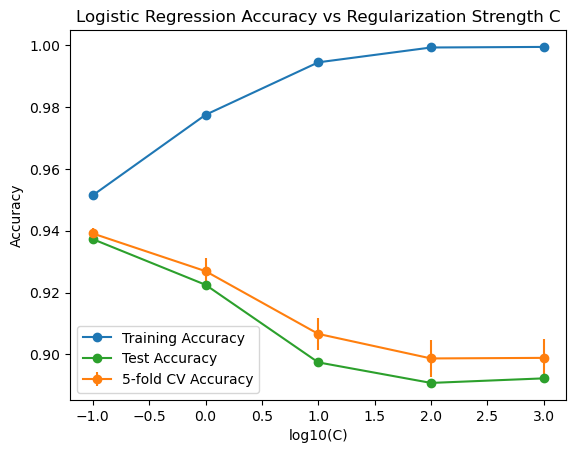

In [45]:
plt.plot(np.log10(C_values), train_acc2, marker='o', label='Training Accuracy')
plt.errorbar(np.log10(C_values), cv_acc2, yerr=cv_std2, marker='o', label='5-fold CV Accuracy')
plt.plot(np.log10(C_values), test_acc2, marker='o', label='Test Accuracy')
plt.xlabel('log10(C)')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Accuracy vs Regularization Strength C')
plt.legend()
plt.show()

In [46]:
best_idx2 = np.argmax(cv_acc2)
best_C = C_values[best_idx2]
print(f"Best C: {best_C} with CV accuracy: {cv_acc2[best_idx2]:.4f} (±{cv_std2[best_idx2]:.4f})")

Best C: 0.1 with CV accuracy: 0.9391 (±0.0018)


In [47]:
final_clf = LogisticRegression(C=best_C, max_iter=1000)
final_clf.fit(X_train2, y_train2)

y_pred2 = final_clf.predict(X_test2)
test_acc2 = accuracy_score(y_test2, y_pred2)
test_error2 = 1 - test_acc2
print(f"Final test set accuracy with C={best_C}: {test_acc2:.4f} ")
print(f"Final test set error with C={best_C}: {test_error2:.4f} ")

Final test set accuracy with C=0.1: 0.9373 
Final test set error with C=0.1: 0.0627 


**Part (d)**

In [48]:
p_tot = y_fp.mean()
p_train = y_train2.mean()
p_test = y_test2.mean()

expected_acc_tot = p_tot**2 + (1 - p_tot)**2
expected_train = p_train**2 + (1 - p_train)**2
expected_test = p_test**2 + (1 - p_test)**2

print(f"p_total={p_tot:.4f}  -> Expected baseline acc ≈ {expected_acc_tot:.4f}")
print(f"p_train={p_train:.4f} -> Expected train acc   ≈ {expected_train:.4f}")
print(f"p_test ={p_test:.4f}  -> Expected test acc    ≈ {expected_test:.4f}")

p_total=0.0624  -> Expected baseline acc ≈ 0.8829
p_train=0.0624 -> Expected train acc   ≈ 0.8830
p_test =0.0627  -> Expected test acc    ≈ 0.8824


In [49]:
rng = np.random.default_rng(0)
y_guess_train = (rng.random(size=y_train2.shape[0]) < p_tot).astype(int)
y_guess_test = (rng.random(size=y_test2.shape[0]) < p_tot).astype(int)

simulated_train_acc = accuracy_score(y_train2, y_guess_train)
simulated_test_acc = accuracy_score(y_test2, y_guess_test)

# From part (c)
final_test_acc2 = accuracy_score(y_test2, y_pred2)

print(f"Simulated random train accuracy: {simulated_train_acc:.4f}")
print(f"Simulated random test accuracy: {simulated_test_acc:.4f}")

print(f"Logistic Regression test accuracy: {test_acc2:.4f}")
print(f"Better than simulated random guessing? {'Yes' if final_test_acc2 > simulated_test_acc else 'No'}")

Simulated random train accuracy: 0.8826
Simulated random test accuracy: 0.8738
Logistic Regression test accuracy: 0.9373
Better than simulated random guessing? Yes


**Part (e)**

In [50]:
cm = confusion_matrix(y_test2, y_pred2, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix (rows = true, columns = predicted):")
print(cm)
print(f"True Negatives: {tn}, False Positives: {fp}")
print(f"False Negatives: {fn}, True Positives: {tp}")

if fp > fn:
    print("Most common error: False Positives (misclassifying non-toxic as toxic)")
elif fn > fp:
    print("Most common error: False Negatives (misclassifying toxic as non-toxic)")
else:
    print("Equal number of False Positives and False Negatives")

Confusion Matrix (rows = true, columns = predicted):
[[1263    7]
 [  78    7]]
True Negatives: 1263, False Positives: 7
False Negatives: 78, True Positives: 7
Most common error: False Negatives (misclassifying toxic as non-toxic)


**Part (f)**

From our analysis of the dataset in part (a), we see the heavy imbalance of our dataset where we only have about 6.6% instances where the molecule is classified as toxic to the p53 protein. From my current experience with ML, there are a few approaches that I know off to combat this bias. Without getting more data, we can oversample our minority class (toxic molecules) by synthetically generating more samples that are classified as toxic. We can also undersample the majority class (non-toxic) by randomly dropping some of the non-toxic samples so that classes get closer to balanced. This approach augments our dataset, which may introduce erroneous deviation from our actual data if not done properly.

In class we learned about weighting the error loss. If we set the class weight = balanced, I believe this would reweight the loss such that errors in the minority class would be greater penalized. With this approach, we do not touch our raw data and we teach the model to essentially prioritize minimizing errors in the class where we have limited data.

My last thought is to use different (and/or multiple) metrics to quantify the model's performance. Accuracy alone may be misleading, so using other metrics like precision, recall, and F1 score may help us create a more robust model that can better account for class imbalance. (I wanted to include this thought because a lot of my work over the summer involved these ideas).